# Example 2

In some cases, one dimension of the data is particularly important for an analysis or exploration. For that reason, STAD implements 1 dimensional lenses (or filters). When used, points that differ in the lens-dimension are separated in the graph, even if they are otherwise similar. This makes it possible to see how data-points differ along the filter-dimension.

This notebook demonstrates how to use a lens and how the STAD network with a lens differs compared to a network without a lens.

In [3]:
import stad as sd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.spatial.distance import pdist
from scipy.sparse import coo_matrix

## The Data

For this notebook we will use the 'circle' data. First a couple of functions used to transform the data.

In [2]:
def rgb_to_hsv(rgb):
    r = float(rgb[0])
    g = float(rgb[1])
    b = float(rgb[2])
    high = max(r, g, b)
    low = min(r, g, b)
    h, s, v = high, high, high

    d = high - low
    s = 0 if high == 0 else d/high

    if high == low:
        h = 0.0
    else:
        h = {
            r: (g - b) / d + (6 if g < b else 0),
            g: (b - r) / d + 2,
            b: (r - g) / d + 4,
        }[high]
        h /= 6

    return h, s, v

def hex_to_rgb(hex):
    hex = hex.lstrip('#')
    hlen = len(hex)
    return list(int(hex[i:i+int(hlen/3)], 16) for i in range(0, hlen, int(hlen/3)))

def hex_to_hsv(hex):
    return rgb_to_hsv(hex_to_rgb(hex))

Now, the data itself:

In [3]:
data = pd.read_csv('./data/five_circles.csv', header=0)
data.head()

x    y      hue
0  377  566  #1F988B
1  362  589  #21A585
2  350  607  #29AF7F
3  104  977  #20928C
4  124  978  #26818E

From this, we can extract a couple of useful variables:

In [4]:
positions = data[['x','y']].to_numpy()
hue_lens = pd.Series(data['hue'].map(lambda x: hex_to_hsv(x)[0]).values)
x_lens = data['x']
rgb = data['hue'].apply(hex_to_rgb).apply(lambda x: [x[0] / 255, x[1] / 255, x[2] / 255])
dist = pdist(positions, 'euclidean')

This dataset has three dimensions. Two dimensions are positional and one is colour. Consequently, we can visualise this data:

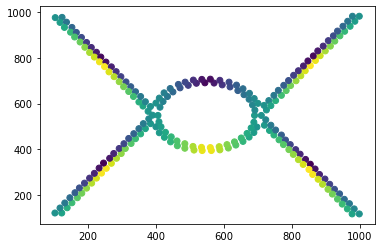

In [5]:
plt.scatter(data['x'], data['y'], c = rgb)
plt.show()

### Without a lens

To see how a lens changes the output of STAD, we first show the network without a lens.

In [6]:
fig = plt.figure(figsize = (8, 6))
(network, sweep) = sd.stad(dist)
sd.plot.network(network, node_color=hue_lens, cmap='viridis', 
                layout='kk', ax = plt.gca())
plt.show()

The loop and four flares are clearly visible in the output network, although a small second loop seems to be present, but that is just the result of the layout algorithm.

### With a lens

Now we will apply a lens on the colour-dimension. To compute STAD with a lens, one should provide a numerical value for each node in the graph and specify the resolution to use. The resolution, or number of bins, balances the global structure with the variation in the lens dimension.

We slightly tuned the exploration parameters to find a good network.

In [7]:
lens = sd.Lens(hue_lens, n_bins=3)
(network, sweep) = sd.stad(dist, lens=lens, edge_penalty=0.1)
sd.plot.sweep(dist, sweep)
plt.show()

After running STAD, the Lens object contains masks indicating which edges in the data cross filter-bin boundaries, which can be informative to visualize. Not all these edges are present in the final network, so we have to apply the network mask that is in the Sweep object after running STAD to correct for this.

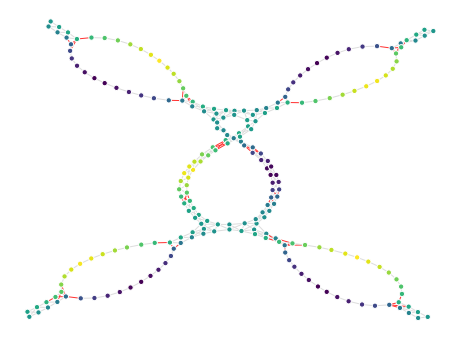

In [8]:
fig = plt.figure(figsize = (8, 6))
edge_color = np.where(lens.adjacent_edges[sweep.network_mask], '#f33', '#ddd')
_ = sd.plot.network(network, cmap='viridis', 
                    node_color=hue_lens, 
                    layout = 'kk',
                    edge_color=edge_color,
                    ax=plt.gca())
plt.show()

The resulting network now has five loops instead of one loop and four flares. The lens on the hue dimension clearly separated nodes that have a similar position but differ in the lens-dimension.

## How does STAD use a lens?

In this section we demonstrate what STAD does internally when a lens is used. Understanding this process will help when exploring your own datasets.

To demonstrate what STAD does internally, we will apply a lens on the x-dimension. The x-dimension is already very present in the STAD network without a lens, so the output will not change much. However, it is easier to demonstrate what STAD does using a position-dimension.

Like before, computing STAD with a lens is simple:

In [9]:
lens = sd.Lens(x_lens, n_bins=3)
(network, sweep) = sd.stad(dist, lens=lens, edge_penalty=0.1)

The `lens` object now contains several usefull variables. One is the intervals in the lens-dimension, providing the break-values of the bins that were used.

In [10]:
lens.bins

array([102.105     , 401.33333333, 699.66666667, 998.        ])

We can use these values to visualise the input data and the lens dimension:

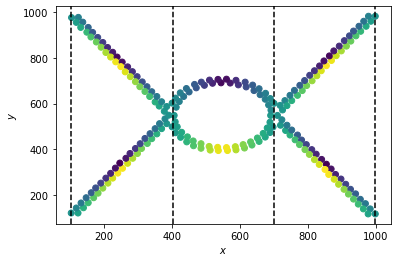

In [11]:
plt.scatter(data['x'], data['y'], c = rgb)
lim = plt.ylim()
for b in lens.bins:
    plt.plot([b, b],lim, 'k--')
    plt.ylim(lim)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()
plt.show()

STAD generaly computes the Minimum Spanning Tree (MST)  of the data and adds edges to it until the correlation with the orignial distance matrix is maximum. When a lens is used, pySTAD supresses ALL edges between nodes that are not in the same or adjacent bins, including in the MST. This ensures that points that differ in the lens dimension become separated in the STAD network. 

Specifically, the distance of all edges to non-adjacent bins is increased such that they will always be considered last when constructing the MST. As shown below, there are no non-adjacent edges in the MST and the Flares are not connected to each other. *Note that the original version (and R implementation) use a different approach to create the MST when using a Lens. See the paper for more details on that approach.*

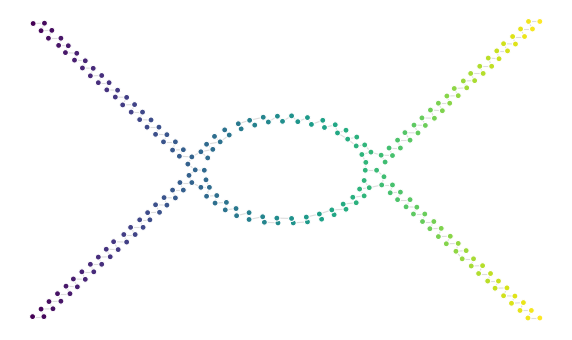

In [12]:
fig = plt.figure(figsize=(10, 6))
edge_color = np.where(lens.non_adjacent_edges[sweep.mst_mask], '#f33', '#ddd')
sd.plot.network(sweep.mst_mask, cmap='viridis', edge_color = edge_color, 
                node_color = x_lens, ax=plt.gca(), positions = positions)
plt.show()

There are a couple of adjectent edges in the network. That is no problem, as they ensure that data-points that are distinct but lie within the same lens bin, remain disconnected.

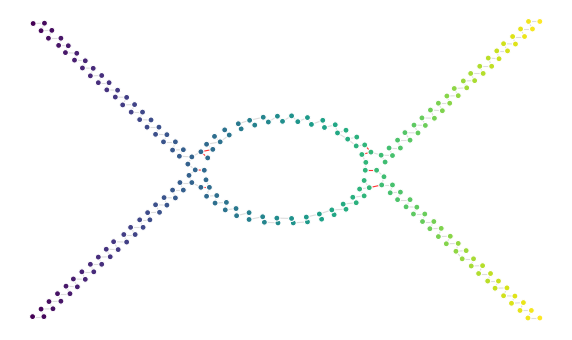

In [13]:
fig = plt.figure(figsize=(10, 6))
edge_color = np.where(lens.adjacent_edges[sweep.mst_mask], '#f33', '#ddd')
sd.plot.network(sweep.mst_mask, cmap='viridis', edge_color = edge_color, 
                node_color = x_lens, ax=plt.gca(), positions = positions)
plt.show()

#### The final STAD network

At this stage, the STAD algorithm is the same as without a lens, except that edges between vertices in non-adjacent lens-bins are not allowed. One should always check the correlation plot to verify whether the network is reasonalbe.

In [14]:
sd.plot.sweep(dist, sweep)
plt.show()

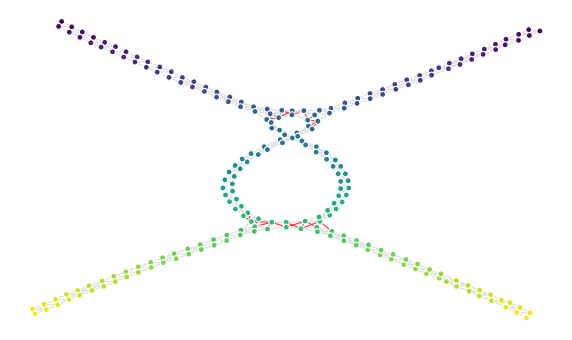

In [15]:
fig = plt.figure(figsize=(10, 6))
edge_color = np.where(lens.adjacent_edges[sweep.network_mask], '#f33', '#ddd')
sd.plot.network(network, cmap='viridis', edge_color = edge_color, 
                node_color = x_lens, ax=plt.gca(), layout='kk')
plt.show()

As expected, for this particular lens, the network did not change much. This section demonstrated that STAD does not allow edges between vertices in non-adjacent bins. Consequently, changing the number of bins in the lens-dimension balances the global structure of the data with the variability in the lens-dimension.

### Combining multiple lenses

The `MultiLens` class is able to combine multiple lens dimensions when constructing a network:

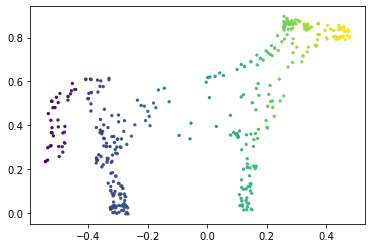

In [12]:
horse = pd.read_csv('./data/horse.csv')
idx = np.random.choice(horse.shape[0], 400, replace=False)
horse = horse.iloc[idx, :]
dist = pdist(horse)
plt.scatter(horse.z, horse.y, s=5, c=horse.z)
plt.show()

In [19]:
lens = sd.MultiLens(sd.Lens(horse.y, n_bins=4), sd.Lens(horse.x, n_bins=6))
net, sweep = sd.stad(dist, lens=lens)
fig = sd.plot.sweep(dist, sweep)
fig = plt.figure(figsize=(8, 6))
_ = sd.plot.network(net, cmap='viridis', node_color = horse.y, ax = plt.gca(), layout='kk')
plt.show()

### Changing the lens resolution

This section provides a quick demonstration on the effect of lens resolution. 

In [18]:
import ipywidgets as widgets
from timeit import default_timer as timer
import datetime

stad_out = sd.Widget()
correlation_out = widgets.Output(layout=widgets.Layout(width='400px'))
text_out = widgets.Output()
lens_bin_slider = widgets.IntSlider(
    value = 20,
    min = 2,
    max = 20,
    step = 1,
    description = '# bins:',
    disabled = False,
    continuous_update = False,
    orientation = 'horizontal',
    readout = True,
    readout_format = 'd'
)

def on_change(change):
    if change['name'] != 'value':
        return

    start = timer()
    lens = sd.Lens(hue_lens, n_bins=lens_bin_slider.value)
    (network, sweep) = sd.stad(dist, lens, edge_penalty=0.1)
    end = timer()
    duration = datetime.timedelta(seconds=end-start)
    
    stad_out.show(network, node_color = hue_lens, node_label=data.x, 
                  link_color=lens.adjacent_edges[sweep.network_mask])
    
    correlation_out.clear_output()
    with correlation_out:
        sd.plot.sweep(dist, sweep)
        plt.show()
    
    text_out.clear_output()
    with text_out:
        print('Computed STAD in: %s' % str(duration))
        print('Distance threshold %.2f' % sweep.best_distance)
        print('Added edges: %d' % sweep.best_added_edges)
        print('Best correlation: %.2f' % sweep.best_correlation)
        print('Best objective: %.2f' % sweep.best_objective)
        
lens_bin_slider.observe(on_change)
lens_bin_slider.value = 3
widgets.HBox([
    widgets.VBox([
        lens_bin_slider,
        text_out,
        correlation_out
    ]),
    stad_out
])

## Filter functions

STAD implements several point-cloud based filter funtions. Like the main `stad()` function, most filters expecte scipy sparse, scipy condensed, or dense distance matrices as input. 

Another source of informattion about most of these functions is [Mapper's documentation](http://danifold.net/mapper/filters.html).

In [17]:
help(sd.lenses)

Help on package stad.lenses in stad:

NAME
    stad.lenses

DESCRIPTION
    This module implements several interesting point-cloud measures that can
    be used as lenses with STAD. Most of these functions are based on the
    documentation of the python implementation of Mapper.
    
    Functions
    ---------
    density :
        Computes the density of each vertex in a point-cloud. Produces high
        values for vertices in regions with many vertices.
    eccentricity :
        Computes the eccentricity of each vertex in a point-cloud. Produces high
        values for vertices in regions with few vertices.
    knn_distance :
        Computes the distance of the k-th closest neighbour for every vertex.
    distance_to_measure :
        Computes the 2-norm of the vector containing the k-th closest neighbours
        for every vertex.
    graph_laplacian :
        Computes eigenvectors of the graph laplacian of the distance matrix,
        following the description in section 4.3 f